In [10]:
import os
from datetime import datetime
from netCDF4 import Dataset
import numpy as np
np.float = float
from matplotlib import gridspec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

In [11]:
datapath_oib = '/Users/carmennab/Dropbox/michel_csao/data/OIB/gridded/var/'
datapath_aspect = '/Users/carmennab/Dropbox/michel_csao/data/ASPeCT/gridded/'
datapath_csao = '/Users/carmennab/cpom_server/home/gch/SS_budget_23/data_in/CSAO/'

In [12]:
csao_aspect = {}
csao_sit = [] ; csao_lidar = [] ; csao_snow = [] ; csao_rfb = []
aspect_sit = [] ; aspect_lidar = [] ; aspect_snow = [] ; aspect_rfb = []

for aspect_file in os.listdir(datapath_aspect):
    date_str = aspect_file.split('.')[0]
    if len(date_str)>0: # skip hidden files
        date = datetime.strptime(date_str, '%Y%m')

        csao_data = Dataset(f'{datapath_csao}fb_sla_cs2_sam_{date.year}.nc')
        try:
            rfb = np.array(csao_data['radar_freeboard_20hz_mean'][int(date.month)-1])
            snow = np.array(csao_data['snow_depth_sd_ASD_sh'][int(date.month)-1])
        except:
            rfb = np.array(csao_data['radar_freeboard_mean'][int(date.month)-1])
            snow = np.array(csao_data['snow_depth_ASD'][int(date.month)-1])            
        lidar = rfb + (snow * ((1 + 0.00051 * 300)**(1.5)))
        
        csao_sit.append(np.array(csao_data['SIT_ASD_mean'][int(date.month)-1]))
        csao_lidar.append(lidar)
        csao_snow.append(snow)
        csao_rfb.append(rfb)

        aspect_data = Dataset(f'{datapath_aspect}{aspect_file}')
        aspect_sit.append(np.array(aspect_data['sea_ice_thickness']))
        aspect_lidar.append(np.array(aspect_data['total_freeboard']))
        aspect_snow.append(np.array(aspect_data['snow_depth']))
        aspect_rfb.append(np.array(aspect_data['radar_freeboard']))
        
csao_aspect['sit'] = csao_sit
csao_aspect['lidar'] = csao_lidar
csao_aspect['snow'] = csao_snow
csao_aspect['rfb'] = csao_rfb

In [13]:
csao_oib = {}
csao_sit = [] ; csao_lidar = [] ; csao_snow = [] ; csao_rfb = []
oib_sit = [] ; oib_lidar = [] ; oib_snow = [] ; oib_rfb = []

for oib_file in os.listdir(datapath_oib):
    date_str = oib_file.split('.')[0]
    if len(date_str)>0: # skip hidden files
        date = datetime.strptime(date_str, '%Y%m%d')

        csao_data = Dataset(f'{datapath_csao}fb_sla_cs2_sam_{date.year}.nc')
        rfb = np.array(csao_data['radar_freeboard_mean'][int(date.month)-1])
        snow = np.array(csao_data['snow_depth_ASD'][int(date.month)-1])
        lidar = rfb + (snow * ((1 + 0.00051 * 300)**(1.5)))
        
        csao_sit.append(np.array(csao_data['SIT_ASD_mean'][int(date.month)-1]))
        csao_lidar.append(lidar)
        csao_snow.append(snow)
        csao_rfb.append(rfb)

        oib_data = Dataset(f'{datapath_oib}{oib_file}')
        oib_sit.append(np.array(oib_data['sea_ice_thickness']))
        oib_lidar.append(np.array(oib_data['laser_freeboard']))
        oib_snow.append(np.array(oib_data['snow_depth']))
        oib_rfb.append(np.array(oib_data['radar_freeboard']))
        
csao_oib['sit'] = csao_sit
csao_oib['lidar'] = csao_lidar
csao_oib['snow'] = csao_snow
csao_oib['rfb'] = csao_rfb

In [14]:
csao_sit = np.array(csao_sit)
# oib_sit = np.array(oib_sit)
# csao_sit[~np.isnan(oib_sit)] = np.nan
# csao_sit[csao_sit<-10] = np.nan
# csao_sit[csao_sit>10] = np.nan
# plt.hist(csao_sit.ravel())
# plt.title('CSAO SIT values that collocate with OIB data',pad=20)
# print(f'number of CSAO SIT values <0.2m: {len(csao_sit[csao_sit<0.2])}')
# print(f'number of CSAO SIT values >0.2m: {len(csao_sit[csao_sit>0.2])}')

In [15]:
figpath = '/Users/carmennab/Dropbox/michel_csao/figures/'

In [16]:
def calculate_bin_width(data, method):
    n = len(data)
    if method == "sturges":
        return int(np.ceil(np.log2(n) + 1))
    elif method == "sqrt":
        return int(np.ceil(np.sqrt(n)))
    elif method == "scott":
        bin_width = 3.5 * np.std(data) / np.cbrt(n)
        return int(np.ceil((data.max() - data.min()) / bin_width))
    elif method == "freedman_diaconis":
        iqr = np.percentile(data, 75) - np.percentile(data, 25)
        bin_width = 2 * iqr / np.cbrt(n)
        return int(np.ceil((data.max() - data.min()) / bin_width))
    else:
        raise ValueError("Unknown method: Choose from 'sturges', 'sqrt', 'scott', or 'freedman_diaconis'")

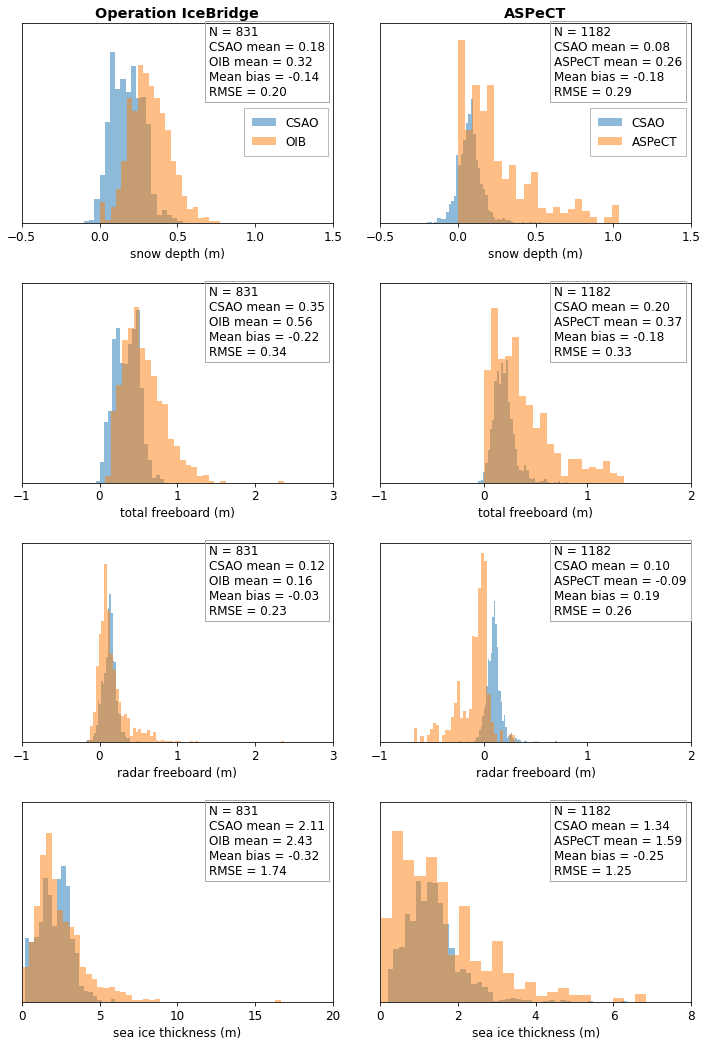

In [17]:
bins_method = 'freedman_diaconis'
plt.rc('font', size=12)
fig = plt.figure(figsize=(12,18))
spec = gridspec.GridSpec(ncols=2, nrows=4, wspace=0.15,hspace=0.3)
csao_vars = [csao_oib['snow'],csao_aspect['snow'],csao_oib['lidar'],csao_aspect['lidar'],csao_oib['rfb'],csao_aspect['rfb'],csao_oib['sit'],csao_aspect['sit']]
ind_vars = [oib_snow,aspect_snow,oib_lidar,aspect_lidar,oib_rfb,aspect_rfb,oib_sit,aspect_sit]
xmins = [-0.5,-0.5,-1,-1,-1,-1,0,0] ; xmaxs = [1.5,1.5,3,2,3,2,20,8]
ymaxs = [125,220,125,200,150,200,150,200]

for count,name in enumerate(['snow depth (m)','snow depth (m)','total freeboard (m)','total freeboard (m)','radar freeboard (m)','radar freeboard (m)','sea ice thickness (m)','sea ice thickness (m)']):
    ax = fig.add_subplot(spec[count])
    
    csao = np.array(csao_vars[count]) ; ind = np.array(ind_vars[count])
    if count  in [0,2,4,6]:
        mask = np.where(~np.isnan(csao) & ~np.isnan(ind) & (np.array(csao_oib['sit'])>0.2))
    else:
        mask = np.where(~np.isnan(csao) & ~np.isnan(ind) & (np.array(csao_aspect['sit'])>0.2))
    ax.hist(csao[mask],label='CSAO',alpha=0.5,bins=calculate_bin_width(csao[mask], bins_method))
    if count in [0,2,4,6]:
        ax.hist(ind[mask],label='OIB',alpha=0.5,bins=calculate_bin_width(ind[mask], bins_method))
    else:
        ax.hist(ind[mask],label='ASPeCT',alpha=0.5,bins=calculate_bin_width(ind[mask], bins_method))
    
    rmse = np.sqrt(np.nanmean((csao[mask]-ind[mask])**2))
    num = len(csao[mask])
    csao_mean = np.nanmean(csao[mask])
    ind_mean = np.nanmean(ind[mask])
    bias = np.nanmean(csao[mask]-ind[mask])
    
    ### textbox moves a big in saved jpg version
    if count in [0,2,4,6]:
        ax.text(0.6, 0.64, f'N = {num}\nCSAO mean = {csao_mean:.2f}\nOIB mean = {ind_mean:.2f}\nMean bias = {bias:.2f}\nRMSE = {rmse:.2f}',transform = ax.transAxes, bbox=dict(facecolor='none',edgecolor='darkgrey'))
    else:
        ax.text(0.56, 0.64, f'N = {num}\nCSAO mean = {csao_mean:.2f}\nASPeCT mean = {ind_mean:.2f}\nMean bias = {bias:.2f}\nRMSE = {rmse:.2f}',transform = ax.transAxes, bbox=dict(facecolor='none',edgecolor='darkgrey'))
    ax.set_xlabel(name,fontsize=12)
    ax.set_xlim([xmins[count],xmaxs[count]])
    ax.set_ylim([0,ymaxs[count]])
    ax.set_yticks([])
    ax.locator_params(axis='both', nbins=5) 
 
    if count == 0:
        ax.set_title('Operation IceBridge', fontweight = 'bold')
    if count in [0,1]:
        legend = ax.legend(bbox_to_anchor=[0.99,0.59])
        frame = legend.get_frame()
        frame.set_edgecolor('darkgrey')
        frame.set_boxstyle('Square')
    if count == 1:
        ax.set_title('ASPeCT', fontweight = 'bold')
        
plt.savefig(f'{figpath}data_comparison.jpg', bbox_inches = "tight", dpi = 400)